<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Initial-conditions" data-toc-modified-id="Initial-conditions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial conditions</a></span><ul class="toc-item"><li><span><a href="#Save-these-into-a-dict-for-later-use" data-toc-modified-id="Save-these-into-a-dict-for-later-use-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Save these into a dict for later use</a></span></li></ul></li><li><span><a href="#Steady-state" data-toc-modified-id="Steady-state-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Steady state</a></span></li><li><span><a href="#Transient-behavior" data-toc-modified-id="Transient-behavior-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transient behavior</a></span></li></ul></div>

# Introduction

Let us recall that $J_{EC}$ and $J_{WC}$ represent the flux of mass [M/T] towards the center. If these are positive, the mass in the center will increase. If there is a source of mass in the center, the mass will increase as well. Therefore, the steady-state equation writes:

\begin{equation}
J_{EC}+J_{WC} + Q = 0
\end{equation}

With Q being written in terms of mg/s (Q: [M/T]) . Therefore mass balance equation with a source term writes:

\begin{equation}
\left( -2  \frac{D\theta}{\Delta x} c_{\left[i\right]}  + \frac{D\theta}{\Delta x}c_{\left[i-1\right]} +   \frac{D\theta}{\Delta x} c_{\left[i+1\right]} \right) \Delta y \Delta z  + q  \Delta x \Delta y \Delta z = 0
\end{equation}

with $q$ being the volumetric source ([M/T/L$^3$])

We can rearrange the latter equation as:

\begin{equation}
\left( 2\frac{D\theta}{\Delta x} c_{\left[i\right]}  - \frac{D\theta}{\Delta x}c_{\left[i-1\right]} -   \frac{D\theta}{\Delta x} c_{\left[i+1\right]} \right) \Delta y \Delta z  = q  \Delta x \Delta y \Delta z
\end{equation}

We can also divide everything by $\Delta x \Delta y \Delta z$:

\begin{equation}
\frac{1}{\Delta x} \left( 2\frac{D\theta}{\Delta x} c_{\left[i\right]}  - \frac{D\theta}{\Delta x}c_{\left[i-1\right]} -   \frac{D\theta}{\Delta x} c_{\left[i+1\right]} \right)   = q
\end{equation}

which gives
\begin{equation}
2\frac{D\theta}{\Delta x^2} c_{\left[i\right]}  - \frac{D\theta}{\Delta x^2}c_{\left[i-1\right]} -   \frac{D\theta}{\Delta x^2} c_{\left[i+1\right]}  = q
\end{equation}

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from IPython.display import HTML
from numpy.testing import assert_allclose

# the next two imports are to show animations and video!

In [2]:
# this function deals with harmonic averaging when diffusion is not the same everywhere.
# It doesn't change anything when diffusion is homogeneous but 
# you can try to see how it affects the behavior.
# To modify a read-only cell, create a new cell below and copy these lines
# into that cell


def avg(Di, Dj):
    """
    Computes the harmonic average between two values Di and Dj
    Returns 0 if either of them is zero
    """
    if (Di * Dj) == 0:
        return 0
    else:
        return 2 / (1 / Di + 1 / Dj)

In [3]:
def Build_1D_Inhomo_Matrix_Source(bc_left, bc_right, n, D, Width, poro, Q):
    """
    Constructs a coefficient matrix and an array with varying diffusion coefficient and a source term

    Parameters
    ----------
    bc_left: (float)
          left boundary condition (mg/L)
    bc_right: (float)
         right boundary condition (mg/L)
    n: (int)
      number of cells
    D: (float vector)
        values of the diffusion coefficient ((dm)^2/day)
    Width: (float)
        Total phyiscal width of the domain (dm)
    poro: (float)
          porosity value
    Q: (float vector)
         volumetric source term (mg/L/day)

    Returns
    -------

    A:  nxn float array
    b: vector of length n

    that solve the
    discretized 1D diffusion problem Ax = b
    """
    Matrix = np.zeros((n, n))
    RHS = np.zeros(n)
    dx = Width / (n - 1)
    coef = poro / dx / dx
    for i in range(n):
        if i == 0:
            RHS[i] = bc_left
            Matrix[i, i] = 1
        elif i == n - 1:
            RHS[i] = bc_right
            Matrix[i, i] = 1
        else:
            RHS[i] = Q[i]
            East = coef * avg(D[i], D[i + 1])
            West = coef * avg(D[i], D[i - 1])
            Matrix[i, i] = East + West
            Matrix[i, i + 1] = -East
            Matrix[i, i - 1] = -West
    return Matrix, RHS

# Initial conditions

We will use similar conditions than in the previous assignment. However, it is a good practise to use units which are representative of the current problem, otherwise we have to deal with very large or very small numbers.

The diffusion coefficient of solutes in pure water is usually 2$\times$10$^{-9}$ m$^2$/s. Concentrations are usually expressed in mg/L, corresponding to mg/dm$^3$. To avoid future unit problems, let us define

- one day as the time unit
- one dm as the length unit (leading to Liters being the adequate volume unit)
- mg as the mass unit

In these units, the diffusion is expressed in dm$^2$/day, the width in dm, and the rate in mg/L/day.
We will here change the values of the parameters used previously..

In [4]:
c_left = 1  # mg/L
c_right = 0  # mg/L
n = 51
Diff = 2e-9 * 100 * 24 * 3600  # dm²/day
D = Diff * np.ones(n)
Q = np.zeros(n)
Q0 = 5e-2  # mg/L/day
Q[int(n / 4) : int(n / 2)] = Q0  # mg/L/day
Width = 2  # dm
poro = 0.4
nTstp = 201
dt = 0.5  # days

c_init = np.zeros((nTstp, n))
c_init[:, 0] = 1  # Boundary condition

In [5]:
# If you want to change the parameters value, you are welcome to do so here.
# But know that your results will be tested based on the parameters given above
# We encourage you to try different things
# For example, you change the diffusion at certain places, change the source term, ...
# Trying out these things will help you build physical intuition
# So we leave this cell for you to change these parameters.
# As before, make a writeable copy of that cell to make changes
#


## Save these into a dict for later use

In [6]:
init_dict = dict(
    c_left=c_left,
    c_right=c_right,
    c_init=c_init,
    n=n,
    Diff=Diff,
    D=D,
    Q=Q,
    Width=Width,
    poro=poro,
    nTstp=nTstp,
    dt=dt,
)

# Steady state

Text(0, 0.5, 'Concentration (mg/L)')

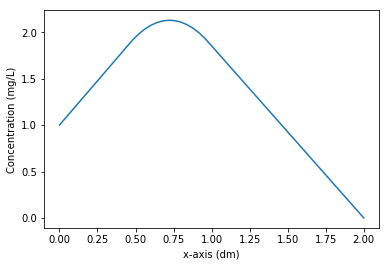

In [7]:
x = np.linspace(0, Width, n)
A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

c_final = np.linalg.solve(A, b)
plt.plot(x, c_final, label="Concentration")
plt.xlabel("x-axis (dm)")
plt.ylabel("Concentration (mg/L)")

# Transient behavior

The transient behavior that we have discussed in the previous notebook simply adds these terms to the previous equation.

\begin{equation}
J_{EC}+J_{WC} + Q = \frac{dm}{dt}
\end{equation}

Using the same developements expressed before, using

\begin{equation}
\frac{d\theta c}{dt} = \theta \frac{c(t+\Delta t) - c(t)}{\Delta t}
\end{equation}

In the following equation, we will write $c(t+\Delta t)$ as $c_i$ (i being the subscript referring to the position index), while $c(t)$ is the old concentration at the same point $c_{i}(\text{old})$.

\begin{equation}
\frac{\theta c_{i}}{\Delta t} + 2\frac{D\theta}{\Delta x^2} c_{i}  - \frac{D\theta}{\Delta x^2}c_{i-1} -   \frac{D\theta}{\Delta x^2} c_{i+1}  = q + \frac{\theta c_{i}(\text{old})}{\Delta t}
\end{equation}

So we can solve this problem by using the same matrixes used before, but we need to add extra terms.

Based on the previous assignment, most of these terms are already incorporated in the matrix A and b. There are only a couple of terms to add to be able to solve the transient problem. We will keep the structure of matrix A and b defined.

You have got to modify the next cell (keep its original structure), and incorporate these new terms in the defined arrays Abis and Bbis.

In [17]:
# HERE YOU HAVE TO ADD TWO LINES OF CODE (see commented lines). 
# WE RECOMMEND THAT YOU DO NOT CHANGE ANYTHING ELSE
# Refer to the equations developed before!


def calc_conc(
    Diff=None,
    D=None,
    Width=None,
    c_left=None,
    c_right=None,
    poro=None,
    Q=None,
    c_init=None,
    n=None,
    nTstp=None,
    dt=None,
):

    x = np.linspace(0, Width, n)
    A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

    c = c_init
    Abis = np.zeros((n, n))
    Bbis = np.zeros(n)

    for t in range(nTstp - 1):
        for i in range(n):
            Abis[i, i] = 0  # Here is where you need to change!
            Bbis[i] = 0  # Here is where you need to change!
        Aa = A + Abis
        bb = b + Bbis
        c[t + 1, :] = np.linalg.solve(Aa, bb)

    return x, c


### BEGIN SOLUTION
def calc_conc(
    Diff=None,
    D=None,
    Width=None,
    c_left=None,
    c_right=None,
    poro=None,
    Q=None,
    c_init=None,
    n=None,
    nTstp=None,
    dt=None,
):

    x = np.linspace(0, Width, n)
    A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

    c = c_init
    Abis = np.zeros((n, n))
    Bbis = np.zeros(n)

    for t in range(nTstp - 1):
        for i in range(n):
            Abis[i, i] = poro / dt  # Here is where you need to change!
            Bbis[i] = c[t, i] * poro / dt  # Here is where you need to change!
        Aa = A + Abis
        bb = b + Bbis
        c[t + 1, :] = np.linalg.solve(Aa, bb)
        #
        # save all work from two timesteps
        #
        if t in [25,26]:
            filename=f"timestep_dump_{t}.npz"
            np.savez(filename,A=A,b=b,Abis=Abis,Bbis=Bbis,Aa=Aa,bb=bb,c=c,x=x,t=t)
    return x, c


### END SOLUTION

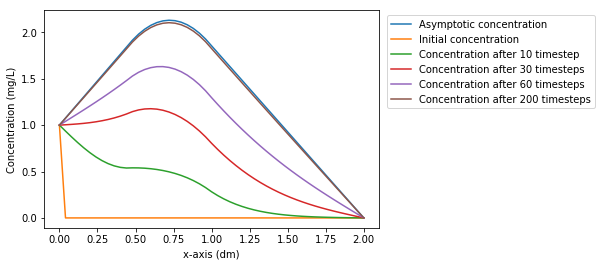

In [9]:
x, c = calc_conc(**init_dict)

plt.plot(x, c_final, label="Asymptotic concentration")
plt.plot(x, c[0, :], label="Initial concentration")
plt.plot(x, c[10, :], label="Concentration after 10 timestep")
plt.plot(x, c[30, :], label="Concentration after 30 timesteps")
plt.plot(x, c[60, :], label="Concentration after 60 timesteps")
plt.plot(x, c[nTstp - 1, :], label="Concentration after 200 timesteps")
plt.xlabel("x-axis (dm)")
plt.ylabel("Concentration (mg/L)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

The next cell tests one of the cell concentrations

In [10]:
# Hidden test for a cell concentration (our choice of cell)
### BEGIN HIDDEN TESTS
assert_allclose(c[100][11], 1.69, rtol=1e-2)
### END HIDDEN TESTS

What is the concentration at 1.6 dm from the left boundary condition after 60 days?
Put this value in the variable answer in the next cell.
That is, replace the line
answer = -1
with your answer

In [11]:
answer = -1
### BEGIN SOLUTION
answer = c[120][40]
### END SOLUTION

In [12]:
# Hidden test for answer
### BEGIN HIDDEN TESTS
assert_allclose(answer, 0.65, rtol=1e-2)
### END HIDDEN TESTS

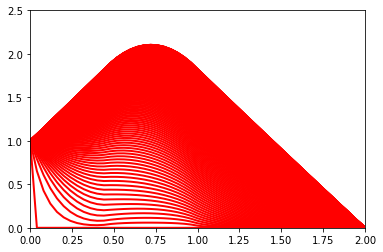

In [13]:


def make_animation(init_dict):
    image_list = []
    x, c = calc_conc(**init_dict)
    fig, ax = plt.subplots()
    ax.set_xlim((0, 2.0))
    ax.set_ylim((0, 2.5))
    nsteps, nvals = c.shape
    for index in range(nsteps):
        line = ax.plot(x, c[index, :], "r-", lw=2)
        image_list.append(line)
    return fig, image_list


fig, image_list = make_animation(init_dict)

In [14]:
# If you want to see the animation, just change movie to True
# (might not work depending on your config and browser, working
# for chrome on macos

movie = True

In [15]:
if movie:
    anim = animation.ArtistAnimation(
        fig, image_list, interval=50, blit=True, repeat_delay=1000
    )

In [16]:
if movie:
    out = HTML(anim.to_html5_video())
    display(out)